#### Import Libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model
from wordcloud import WordCloud
import pickle
import nltk
import warnings
from nltk.corpus import stopwords

nltk.download('stopwords')

warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Merging the Dataset

In [130]:
def concatenate_files(file_list, output_file):
    with open(output_file, 'w') as outfile:
        for file_name in file_list:
            with open(file_name, 'r') as infile:
                for line in infile:
                    outfile.write(line)

file_list = ['train.txt', 'test.txt', 'val.txt']
output_file = 'dataset.txt'

concatenate_files(file_list, output_file)

print("Files concatenated successfully as 'dataset.txt'")

Files concatenated successfully as 'dataset.txt'


#### Load the Dataset

In [131]:
df = pd.read_csv("dataset.txt", delimiter=';', header=None, names=['Sentences', 'Target'])
sentences = df['Sentences'].values
emotions = df['Target'].values

#### Dataset Exploration

In [79]:
print(df.head())

                                           Sentences   Target
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [80]:
print(df.shape)

(20000, 2)


In [81]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentences  20000 non-null  object
 1   Target     20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB
None


In [82]:
df.isnull().sum()

Sentences    0
Target       0
dtype: int64

In [83]:
print(df['Target'].unique())

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [84]:
print((df.Target.value_counts() / df.shape[0] * 100).round(2))

Target
joy         33.80
sadness     28.98
anger       13.54
fear        11.86
love         8.20
surprise     3.60
Name: count, dtype: float64


#### Distribution of Target Variable

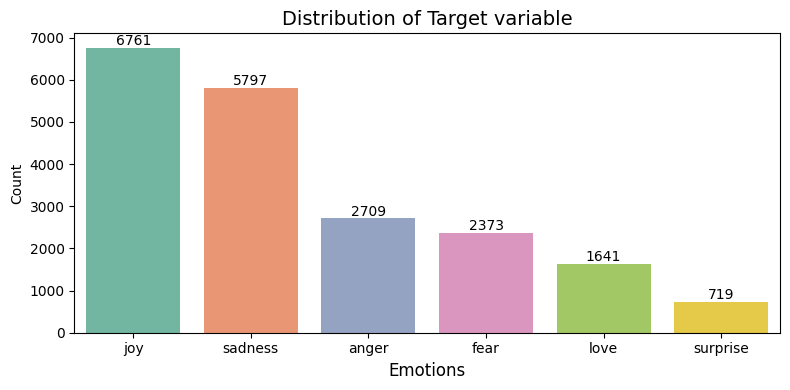

In [85]:
plt.figure(figsize=(8, 4))

ax = sns.countplot(x='Target', data=df, palette='Set2', order=df['Target'].value_counts().index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 5),
                   textcoords = 'offset points')

plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Target variable', fontsize=14)

plt.tight_layout()
plt.show()

In [86]:
df["Sentences_length"] = [len(i) for i in df["Sentences"]]

In [87]:
df.head(5)

,Sentences,Target,Sentences_length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


#### Max and Min Sentence length

In [88]:
print(df['Sentences_length'].max())
print(df['Sentences_length'].min())

300
7


<Axes: xlabel='Sentences_length', ylabel='Density'>

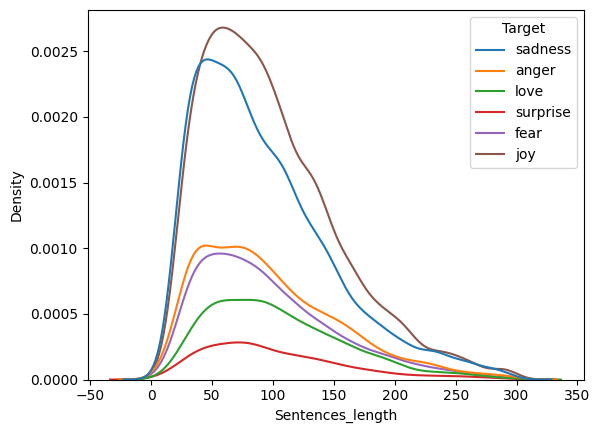

In [89]:
sns.kdeplot(x=df["Sentences_length"], hue=df["Target"])

#### Number of Stopwords by Sentences

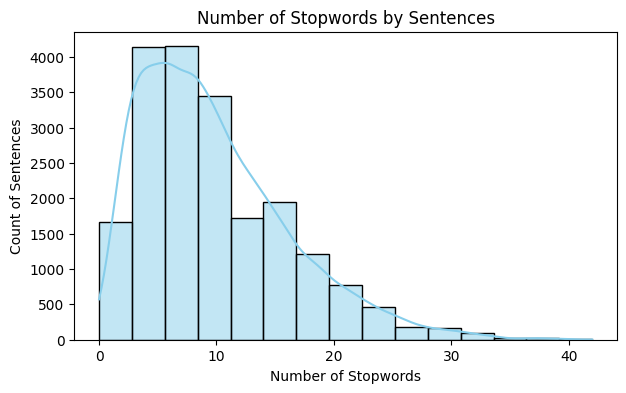

In [105]:
def count_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = sentence.split()
    return sum(1 for word in tokens if word.lower() in stop_words)

df['Stopword_Count'] = df['Sentences'].apply(count_stopwords)

plt.figure(figsize=(7, 4))
sns.histplot(df['Stopword_Count'], bins=15, kde=True, color='Skyblue')
plt.xlabel('Number of Stopwords')
plt.ylabel('Count of Sentences')
plt.title('Number of Stopwords by Sentences')
plt.show()

#### Removing the Stopwords

In [106]:
stop_words = set(stopwords.words('english'))

In [107]:
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df['Sentences'] = df['Sentences'].apply(remove_stopwords)

#### Plot for words in Sentences after stopwords removal

<Axes: xlabel='Sentences', ylabel='Density'>

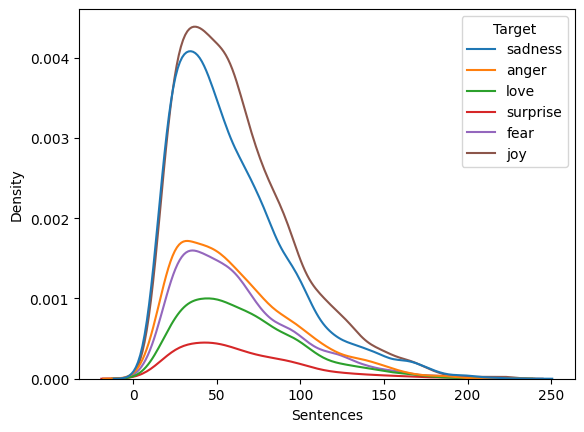

In [108]:
sns.kdeplot(data=df, x=df["Sentences"].str.len(), hue=df["Target"])

#### Word Cloud for Different Emotions

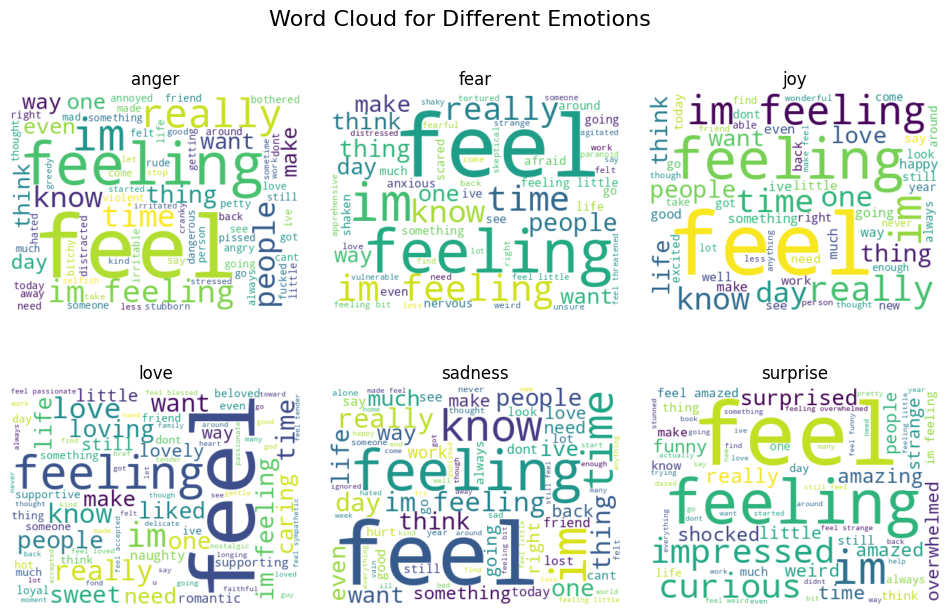

In [109]:
def generate_wordcloud(category_sentences, ax, title):
    wordcloud = WordCloud(width=400, height=300, background_color ='white', min_font_size = 10).generate(' '.join(category_sentences))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

category_groups = df.groupby('Target')['Sentences'].apply(list)

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace=0.1)

for i, (category, sentences) in enumerate(category_groups.items()):
    row = i // 3
    col = i % 3
    generate_wordcloud(sentences, axs[row, col], category)

plt.suptitle('Word Cloud for Different Emotions', fontsize=16)

plt.show()

In [116]:
df.drop(["Sentences_length","Stopword_Count"],axis = 1)

,Sentences,Target
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
19995,im ssa examination tomorrow morning im quite w...,sadness
19996,constantly worry fight nature push limits inne...,joy
19997,feel important share info experience thing,joy
19998,truly feel passionate enough something stay tr...,joy


#### Downloading the Pretrained Model - GLoVe

In [35]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

--2024-05-07 14:45:48--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 65.8.178.12, 65.8.178.118, 65.8.178.93, ...
Connecting to huggingface.co (huggingface.co)|65.8.178.12|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1715352348&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTM1MjM0OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=elvMx%7EY0z8LyztBDd3Ic-wEEGYpU1c

In [36]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

#### Load the model

In [37]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open('glove.6B.300d.txt','r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [38]:
glove_model = load_glove_model('glove.6B.300d.txt')

Loading Glove Model
400001 words loaded!


#### Tokenize the sentences and create word-to-index mapping

In [161]:
word_to_index = {}
index = 1  # Start index from 1, leaving 0 for padding
for sentence in sentences:
    for word in sentence.split():
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

#### Creating an embedding matrix

In [136]:
embedding_matrix = np.zeros((len(word_to_index) + 1, len(glove_model['the'])))  # Add 1 to include padding token
for word, index in word_to_index.items():
    if word in glove_model:
        embedding_matrix[index] = glove_model[word]

#### Performing label encoding on the target labels

In [137]:
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions)

#### Split the dataset into training, validation, and testing sets

In [138]:
X_train, X_test, y_train, y_test = train_test_split(sentences, encoded_emotions, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### Converting sentences to sequences of indices

In [139]:
X_train_sequences = [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in X_train]
X_val_sequences = [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in X_val]
X_test_sequences = [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in X_test]

#### Padding sequences to make them of equal length

In [140]:
max_sequence_length = max(len(sequence) for sequence in X_train_sequences + X_val_sequences + X_test_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

#### Train the Model

In [141]:
bilstm_model = Sequential([
    Embedding(input_dim=len(word_to_index) + 1, output_dim=len(glove_model['the']), weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.2),  # Dropout layer added after the Bidirectional LSTM layer
    Dense(len(label_encoder.classes_), activation='softmax')
])
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [159]:
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 300)           5129100   
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 5316754 (20.28 MB)
Trainable params: 187654 (733.02 KB)
Non-trainable params: 5129100 (19.57 MB)
_________________________________________________________________


In [142]:
bilstm_history = bilstm_model.fit(X_train_padded, y_train, epochs=25, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

Epoch 1/25
450/450 [==============================] - 172s 369ms/step - loss: 1.2147 - accuracy: 0.5519 - val_loss: 0.7651 - val_accuracy: 0.7163
Epoch 2/25
450/450 [==============================] - 166s 368ms/step - loss: 0.6749 - accuracy: 0.7642 - val_loss: 0.4767 - val_accuracy: 0.8300
Epoch 3/25
450/450 [==============================] - 219s 488ms/step - loss: 0.4701 - accuracy: 0.8383 - val_loss: 0.3492 - val_accuracy: 0.8662
Epoch 4/25
450/450 [==============================] - 149s 332ms/step - loss: 0.3659 - accuracy: 0.8722 - val_loss: 0.3035 - val_accuracy: 0.8869
Epoch 5/25
450/450 [==============================] - 160s 357ms/step - loss: 0.3098 - accuracy: 0.8865 - val_loss: 0.2732 - val_accuracy: 0.8950
Epoch 6/25
450/450 [==============================] - 146s 325ms/step - loss: 0.2547 - accuracy: 0.9043 - val_loss: 0.2493 - val_accuracy: 0.9050
Epoch 7/25
450/450 [==============================] - 153s 341ms/step - loss: 0.2297 - accuracy: 0.9133 - val_loss: 0.2251 -

#### Evaluating the model

In [143]:
loss, accuracy = bilstm_model.evaluate(X_test_padded, y_test)
print("BiLSTM Accuracy:", accuracy)

125/125 [==============================] - 5s 41ms/step - loss: 0.2327 - accuracy: 0.9062
BiLSTM Accuracy: 0.90625


In [145]:
y_pred_prob = bilstm_model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

125/125 [==============================] - 18s 122ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.93      0.91       536
        fear       0.86      0.83      0.84       458
         joy       0.94      0.92      0.93      1339
        love       0.78      0.84      0.81       335
     sadness       0.95      0.94      0.95      1173
    surprise       0.73      0.85      0.78       159

    accuracy                           0.91      4000
   macro avg       0.86      0.88      0.87      4000
weighted avg       0.91      0.91      0.91      4000



#### Plot for training and validation loss

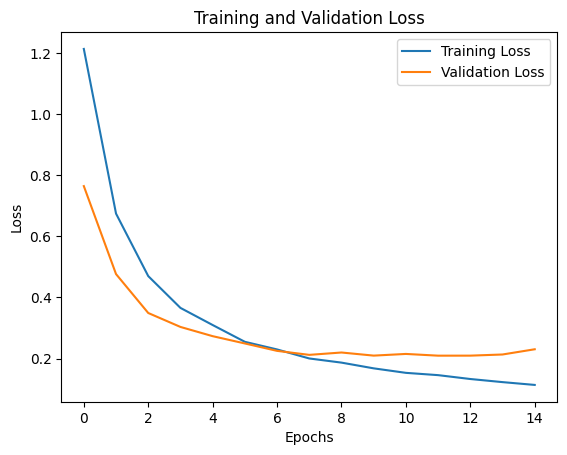

In [146]:
plt.plot(bilstm_history.history['loss'], label='Training Loss')
plt.plot(bilstm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot for training and validation accuracy

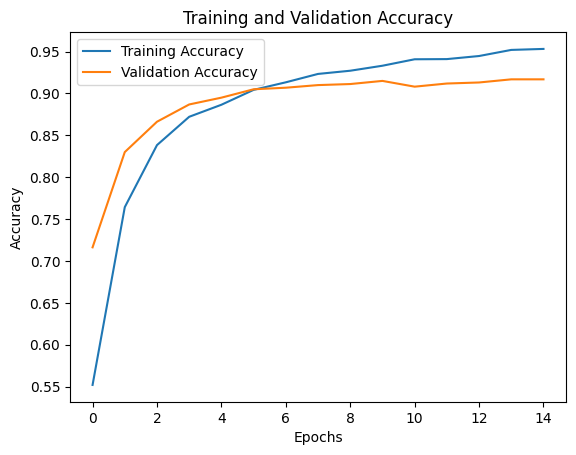

In [147]:
plt.plot(bilstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Predicting New Sentences

In [154]:
new_sentences = [
    "I feel excited about the upcoming project",
    "This situation makes me anxious",
    "I am calm and relaxed right now"
]

tokenizer = lambda x: [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in x]

new_sequences = tokenizer(new_sentences)
new_sequences_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')

predictions = bilstm_model.predict(new_sequences_padded)

predicted_emotions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("Predicted Emotions for New Sentences:")
for sentence, emotion in zip(new_sentences, predicted_emotions):
    print(f"Sentence: {sentence} | Predicted Emotion: {emotion}")

1/1 [==============================] - 1s 1s/step
Predicted Emotions for New Sentences:
Sentence: I feel excited about the upcoming project | Predicted Emotion: joy
Sentence: This situation makes me anxious | Predicted Emotion: fear
Sentence: I am calm and relaxed right now | Predicted Emotion: joy


#### Save Model

In [157]:
bilstm_model.save('bilstm_model.h5')

with open('bilstm_model.pkl', 'wb') as f:
    pickle.dump(bilstm_model, f)

print("Model saved successfully!")

Model saved successfully!
